In [1]:
import datetime
import pandas as pd
from influxdb import DataFrameClient
import matplotlib
import matplotlib.pyplot as plt
import json
import pytz
import numpy as np
import yaml


import seaborn as sns
import matplotlib.mlab as mlab
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline

In [ ]:
#important things: total building load, pv generation, (building_power), battery total stored vs current stored,
#show that battery worked well, (how battery reacted to load)
#Last Thursday, battery didn't respond
#Outdoor temperature, how did systems resond?
#matplotlib.plot, dataframe Column

In [2]:
with open('config.yaml') as fp:
    config = yaml.safe_load(fp)
database_config = config.get('database')

In [3]:
with open('uuid_map.json') as fp:
    uuid_map = json.load(fp)

In [4]:
client = DataFrameClient(
    host=database_config.get('host'), 
    port=database_config.get('port'), 
    username=database_config.get('username'), 
    password=database_config.get('password'), 
    database=database_config.get('database'), 
    ssl=database_config.get('ssl'), 
    verify_ssl=database_config.get('verify_ssl')
)

In [6]:
tz_local = pytz.timezone('America/Los_Angeles')
tz_utc = pytz.timezone('UTC')

In [93]:
uuid_dict = {
    'building_power': uuid_map['xbos/wattnode/building_main/PowerSum'], #watts
    'freezer_power': uuid_map['xbos/wattnode/fre_comp_evapfan/PowerSum'],
    'ref_comp_power': uuid_map['xbos/wattnode/ref_comp/PowerSum'],
    'ref_fan_power': uuid_map['xbos/wattnode/ref_evapfan/PowerSum'],
    'hvac_west_power': uuid_map['xbos/wattnode/hvac_west_comp/PowerSum'],
    'hvac_east_power': uuid_map['xbos/wattnode/hvac_east_comp/PowerSum'],
    
    'east_temperature': uuid_map['xbos/flexstat/thermostat_east/space_temp'], #F
    'west_temperature': uuid_map['xbos/flexstat/thermostat_west/space_temp'],
    'freezer_temperature': uuid_map['xbos/parker/freezer/CabinetTemperature'],
    'ref_temperature': uuid_map['xbos/parker/refrigerator/CabinetTemperature'],
    
    'east_heating_sp': uuid_map['xbos/flexstat/thermostat_east/active_heating_setpt'], #F
    'east_cooling_sp': uuid_map['xbos/flexstat/thermostat_east/active_cooling_setpt'],
    'west_heating_sp': uuid_map['xbos/flexstat/thermostat_west/active_heating_setpt'],
    'west_cooling_sp': uuid_map['xbos/flexstat/thermostat_west/active_cooling_setpt'],
    'freezer_sp': uuid_map['xbos/parker/freezer/Setpoint'],
    'ref_sp': uuid_map['xbos/parker/refrigerator/Setpoint'],
    
    'soc_battery': '0efc4fa5-755c-5c45-863a-c0c776ab7538', #0-1
    'setpoint_battery': '276ea28f-0f74-5b3e-9ad1-f3b9f747dbe4', #watts
    'pv_generation_battery': 'fdfd7bbb-d2da-5b11-a8fa-58b231ab9802', #watts
    # below is real battery, above simulated
    'total_capacity_battery': 'b55d3081-4678-55ec-9545-bbbcfd544c1f', #watt-hours; move to rtac because real values
    'current_stored_energy_battery': 'b5619f4e-b83d-567c-a197-254d36a9e885',#watt-hours
    
    'oat_current': 'f7c1f2c8-c996-528c-ab3d-bdc96dc9cf72', #F
    'humidity_current': '7967b372-2699-57e1-bc15-7861bfe6d024',#0-100%
    'windspeed_current': 'ac555599-0403-5bea-8441-f39a4e8e0dac', # m/s
    'cloudcover_current': '6cce3e9a-3822-551b-b13c-f4b874f3afa1', # 0-1, 1 being cloudy
    'solar_current': 'd15979be-7a63-5230-9e7b-d068d9f40b08',    #watt/m^2
    
    'oat_forecast': '69be4db0-48f5-592f-b5a1-e2e695f28ad1', #as above, forecast predicts next 48 hours
    'humidity_forecast': 'c2379487-3df3-5bfe-bd8d-5992d2381ed5',
    'windspeed_forecast': '837d0588-b30a-56ee-920f-cf366fa0871f',
    'cloudcover_forecast': '6f93857f-50a6-5b9f-8b94-0231f511b382',
    'solar_forecast': 'a8357adb-c59d-5316-a0e8-51d2b2948c75',
    
    'price_energy_dr': '3be4c234-a38a-5e73-9d53-4503751592be', #$/kW*Hours
    'price_demand_dr': '90928e8d-df40-5e75-9ddb-7ee444bc187f', #$/kW
    'pmax_dr': '522605a9-77b1-57e3-9fac-06dd83ab8e89', #maximum power for mpc +999999, changes during demand response events
    'pmin_dr': '6b42adf8-3a48-5ae7-bdc3-19226e602865' #min power, default is -999999
    
    'pv_generation_rtac': 'd4102860-1f55-5e14-b02d-8bdb9e987676', #Watts, real PV generation
    'soc_rtac': '944a5aba-8c59-586e-af87-d95151596cf1' # real state of charge %
}

In [8]:
def parse_dt_utc(dt):
    return tz_local.localize(datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)

In [9]:
def current_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [10]:
def forecast_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and \"prediction_step\" = '1' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [11]:
def get_data_section(client, endswith, st, et, uuid_dict, resample='1T', current=True):
    df_list = []
    for variable in uuid_dict:
        if variable.endswith(endswith):
            uuid = uuid_dict[variable]
            if current:
                df = current_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            else:
                df = forecast_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            df = df.resample(resample).mean()
            df_list.append(df)
    return pd.concat(df_list, axis=1)

In [12]:
st = "2020-08-21 00:00:00"
et = "2020-08-21 23:59:59"

In [13]:
power_df = get_data_section(client, '_power', st, et, uuid_dict, '1T')
power_df = power_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
power_df.head()
power_df['total']=power_df.sum(axis=1)
power_df.head()


,building,freezer,ref_comp,ref_fan,hvac_west,hvac_east,total
2020-08-21 00:00:00,36200.284538,3061.827464,1486.728420,300.399154,359.927419,6431.847656,47841.014650
2020-08-21 00:30:00,35563.311328,2966.010902,1250.628675,304.146858,359.809385,6455.518457,46899.425605
2020-08-21 01:00:00,32299.625781,2851.497018,1413.642105,294.074028,360.109544,3650.913055,40869.861532
2020-08-21 01:30:00,34951.085286,3144.843036,1398.562721,307.575460,359.828784,5662.229574,45824.124862
2020-08-21 02:00:00,37574.709115,3008.833957,1434.490931,294.359061,360.478386,6042.429242,48715.300692


In [14]:
setpoint_df = get_data_section(client, '_sp', st, et, uuid_dict, '1T')
setpoint_df = setpoint_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
setpoint_df.head()

,east_heating,east_cooling,west_heating,west_cooling,freezer,ref
2020-08-21 00:00:00,68.0,70.0,68,70,-7.0,33
2020-08-21 00:30:00,68.0,70.0,68,70,-7.0,33
2020-08-21 01:00:00,68.0,70.0,68,70,-7.0,33
2020-08-21 01:30:00,68.0,70.0,68,70,-7.0,33
2020-08-21 02:00:00,68.0,70.0,68,70,-7.0,33


In [15]:
temperature_df = get_data_section(client, '_temperature', st, et, uuid_dict, '1T')
temperature_df = temperature_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
temperature_df.head()

,east,west,freezer,ref
2020-08-21 00:00:00,70.796666,68.649665,-5.200000,34.400000
2020-08-21 00:30:00,70.605665,68.636999,-5.233333,34.400000
2020-08-21 01:00:00,70.350332,68.399333,-5.366667,34.366667
2020-08-21 01:30:00,70.637666,68.900998,-5.200000,34.366667
2020-08-21 02:00:00,70.920999,68.915998,-5.433333,34.300000


In [16]:
battery_df = get_data_section(client, '_battery', st, et, uuid_dict, '1T')
battery_df = battery_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
battery_df.head()

,soc,setpoint,pv_generation,total_capacity,current_stored_energy
2020-08-21 00:00:00,0.454153,0,0.0,159876.766667,127738.533333
2020-08-21 00:30:00,0.454153,0,0.0,165389.733333,149702.333333
2020-08-21 01:00:00,0.454153,0,0.0,137827.566667,129934.766667
2020-08-21 01:30:00,0.454153,0,0.0,165363.933333,155935.666667
2020-08-21 02:00:00,0.454153,0,0.0,104718.966667,98583.200000


In [94]:
weather_df = get_data_section(client, '_current', st, et, uuid_dict, '1T')
weather_df = weather_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
weather_df.head()

,oat,humidity,windspeed,cloudcover,solar
2020-08-21 07:13:00+00:00,61.65,82.0,2.77,0.21,0.0
2020-08-21 07:14:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-08-21 07:15:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-08-21 07:16:00+00:00,NaN,NaN,NaN,NaN,NaN
2020-08-21 07:17:00+00:00,NaN,NaN,NaN,NaN,NaN


In [18]:
rtac_df = get_data_section(client, '_rtac', st, et, uuid_dict, '1T')
rtac_df = rtac_df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()
rtac_df.head()

,pv_generation,soc
2020-08-21 00:00:00,0.0,0.772349
2020-08-21 00:30:00,0.0,0.905149
2020-08-21 01:00:00,0.0,0.785612
2020-08-21 01:30:00,0.0,0.942985
2020-08-21 02:00:00,0.0,0.596225


In [19]:
dr_df = get_data_section(client, '_dr', st, et, uuid_dict, '60T', current=False)
dr_df = dr_df.tz_convert(tz_local).tz_localize(None).resample('1T').fillna(method='ffill')
dr_df.head()

,price_energy,price_demand,pmax,pmin
2020-08-21 00:00:00,0.04026,0.0,999999,-999999
2020-08-21 00:01:00,0.04026,0.0,999999,-999999
2020-08-21 00:02:00,0.04026,0.0,999999,-999999
2020-08-21 00:03:00,0.04026,0.0,999999,-999999
2020-08-21 00:04:00,0.04026,0.0,999999,-999999


In [20]:
battery_df.head()

,soc,setpoint,pv_generation,total_capacity,current_stored_energy
2020-08-21 00:00:00,0.454153,0,0.0,159876.766667,127738.533333
2020-08-21 00:30:00,0.454153,0,0.0,165389.733333,149702.333333
2020-08-21 01:00:00,0.454153,0,0.0,137827.566667,129934.766667
2020-08-21 01:30:00,0.454153,0,0.0,165363.933333,155935.666667
2020-08-21 02:00:00,0.454153,0,0.0,104718.966667,98583.200000


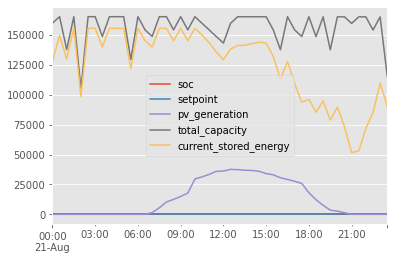

In [21]:
battery_df.plot()

In [22]:
net_power_df=battery_df.copy()
net_power_df['building_draw']=power_df['building']
net_power_df['rtac_pv_generation']=rtac_df['pv_generation']
net_power_df.head(10)

,soc,setpoint,pv_generation,total_capacity,current_stored_energy,building_draw,rtac_pv_generation
2020-08-21 00:00:00,0.454153,0,0.0,159876.766667,127738.533333,36200.284538,0.0
2020-08-21 00:30:00,0.454153,0,0.0,165389.733333,149702.333333,35563.311328,0.0
2020-08-21 01:00:00,0.454153,0,0.0,137827.566667,129934.766667,32299.625781,0.0
2020-08-21 01:30:00,0.454153,0,0.0,165363.933333,155935.666667,34951.085286,0.0
2020-08-21 02:00:00,0.454153,0,0.0,104718.966667,98583.200000,37574.709115,0.0
2020-08-21 02:30:00,0.454153,0,0.0,165349.000000,155630.433333,36428.823763,0.0
2020-08-21 03:00:00,0.454153,0,0.0,165351.433333,155618.066667,29958.400781,0.0
2020-08-21 03:30:00,0.454153,0,0.0,148818.100000,140066.566667,35662.858561,0.0
2020-08-21 04:00:00,0.454153,0,0.0,165353.300000,155625.133333,32642.135840,0.0
2020-08-21 04:30:00,0.454153,0,0.0,165353.233333,155625.100000,36290.304492,0.0


## Data Cleaning

### Check Missing Data (no missing data on 21st)

In [23]:
def get_heatmap(df):
    cols = df.columns
    colors = ['#000080', '#ffd700']
    sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors)) #navy data is there, gold is not (go bears)

In [24]:
def missing_data_percent(df):
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [25]:
#all_df=power_df.append([setpoint_df,temperature_df, battery_df, weather_df, rtac_df, dr_df],sort=True)
#all_df=pd.concat([setpoint_df,temperature_df, battery_df, weather_df, rtac_df, dr_df],axis=1,sort=True)

In [26]:
dfs=[power_df,setpoint_df,temperature_df, battery_df, weather_df, rtac_df, dr_df]

In [27]:
for df in dfs:
    missing_data_percent(df)

building - 0.0%
freezer - 0.0%
ref_comp - 0.0%
ref_fan - 0.0%
hvac_west - 0.0%
hvac_east - 0.0%
total - 0.0%
east_heating - 0.0%
east_cooling - 0.0%
west_heating - 0.0%
west_cooling - 0.0%
freezer - 0.0%
ref - 0.0%
east - 0.0%
west - 0.0%
freezer - 0.0%
ref - 0.0%
soc - 0.0%
setpoint - 0.0%
pv_generation - 0.0%
total_capacity - 0.0%
current_stored_energy - 0.0%
oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%
pv_generation - 0.0%
soc - 0.0%
price_energy - 0.0%
price_demand - 0.0%
pmax - 0.0%
pmin - 0.0%


In [28]:
missing_data_percent(weather_df)

oat - 0.0%
humidity - 0.0%
windspeed - 0.0%
cloudcover - 0.0%
solar - 0.0%


In [ ]:
get_heatmap(weather_df)

### Removing Outliers

In [43]:
#User Preferences
tol=1.5 #the amount of interquartile ranges a value can be from the first or third quartile

In [30]:
def check(df):
    print(get_df_name(df))
    #df.plot()
    #plt.show()
    df.boxplot()
    plt.show()
    #display(df.describe())

In [35]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [44]:
#considering interpolating values rather than just removing them, may unnecessarily weight data so will do that later
def remove_quantile_outliers(df):
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1   
        filter = (df[col] >= q1-tol*iqr) & (df[col] <= q3+tol*iqr)
        df[col]=df[col].loc[filter] 

In [45]:
def copy_dfs(dfs):
    copy_dfs={}
    for df in dfs:
        copy_dfs[get_df_name(df)]=df.copy()
    return copy_dfs
    

power_df


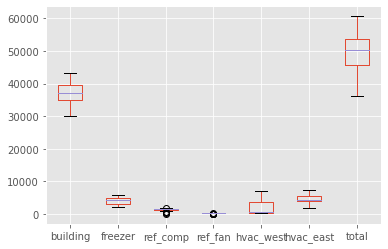

setpoint_df


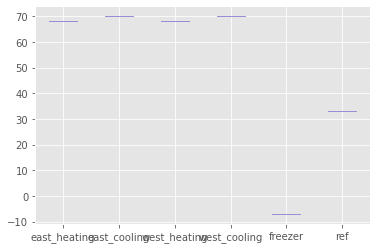

temperature_df


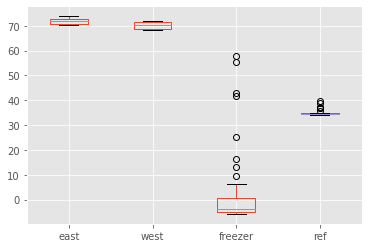

battery_df


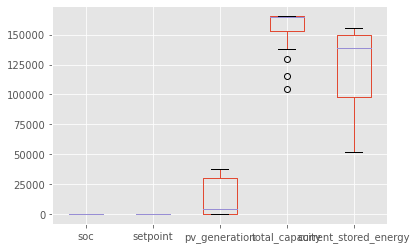

weather_df


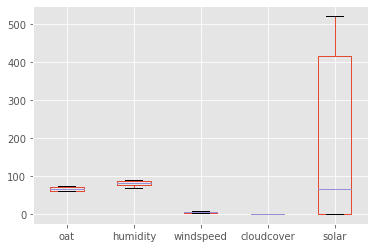

rtac_df


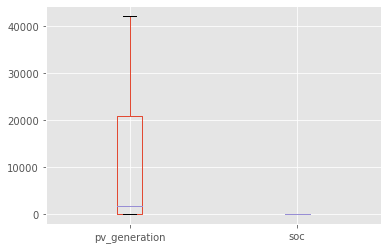

dr_df


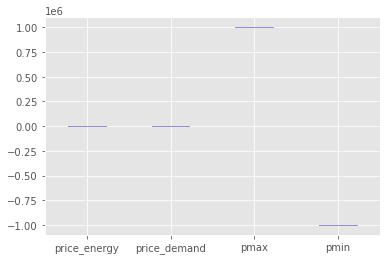

In [36]:
for df in dfs:
    check(df)

In [47]:
uncleaned_dfs=copy_dfs(dfs)

uncleaned_dfs['power_df'].head(3)

,building,freezer,ref_comp,ref_fan,hvac_west,hvac_east,total
2020-08-21 00:00:00,36200.284538,3061.827464,1486.728420,300.399154,359.927419,6431.847656,47841.014650
2020-08-21 00:30:00,35563.311328,2966.010902,1250.628675,304.146858,359.809385,6455.518457,46899.425605
2020-08-21 01:00:00,32299.625781,2851.497018,1413.642105,294.074028,360.109544,3650.913055,40869.861532


In [48]:
for df in dfs:
    remove_quantile_outliers(df)

power_df


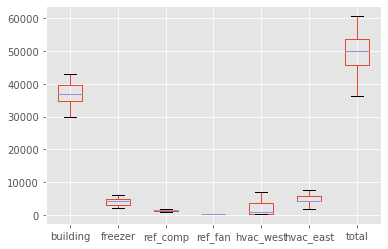

setpoint_df


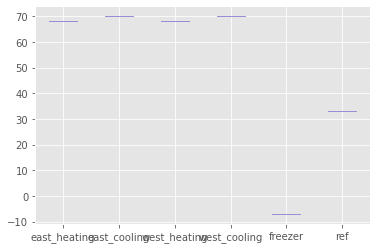

temperature_df


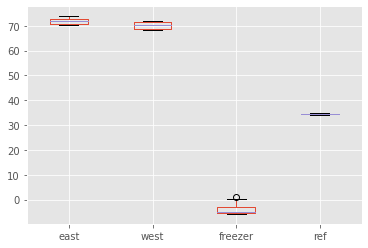

battery_df


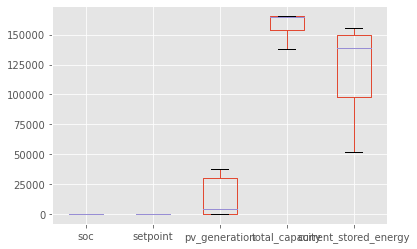

weather_df


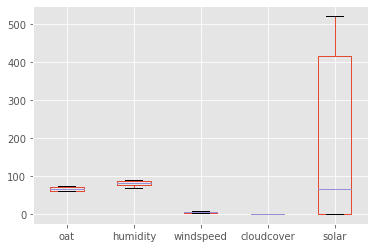

rtac_df


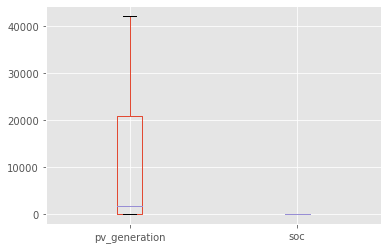

dr_df


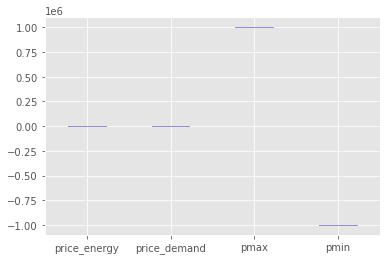

In [49]:
for df in dfs:
    check(df)

### Looking at SOC%

In [51]:
battery_df.head(20)

,soc,setpoint,pv_generation,total_capacity,current_stored_energy
2020-08-21 00:00:00,0.454153,0,0.000000,159876.766667,127738.533333
2020-08-21 00:30:00,0.454153,0,0.000000,165389.733333,149702.333333
2020-08-21 01:00:00,0.454153,0,0.000000,137827.566667,129934.766667
2020-08-21 01:30:00,0.454153,0,0.000000,165363.933333,155935.666667
2020-08-21 02:00:00,0.454153,0,0.000000,NaN,98583.200000
2020-08-21 02:30:00,0.454153,0,0.000000,165349.000000,155630.433333
2020-08-21 03:00:00,0.454153,0,0.000000,165351.433333,155618.066667
2020-08-21 03:30:00,0.454153,0,0.000000,148818.100000,140066.566667
2020-08-21 04:00:00,0.454153,0,0.000000,165353.300000,155625.133333
2020-08-21 04:30:00,0.454153,0,0.000000,165353.233333,155625.100000


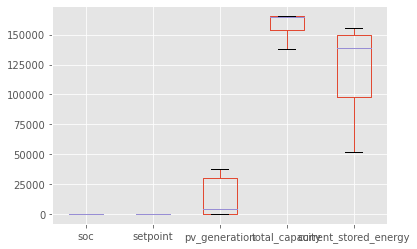

In [52]:
battery_df.boxplot()

In [72]:
bdf=battery_df.copy()

In [74]:
# if multiple NaN values, split dataframe then check for first non-null index and use that, or iterate in for loop if null. iterate in for loop may be better since double NaN's are uncommon

In [90]:
def intp_on_null(df,NullCol,interpCols):
#     top_ind = df[nan_inds[i]:, :].first_valid_index()
#     bot_ind = df[:nan_ind[i], :].iloc[::-1].first_valid_index() #::-1 reverses it but I don't understand how
#     top_val=df[col][top_ind]
#     bot_val=df[col][bot_ind]
#     m=(top_val-bot_val)/
#     battery_df[col][nan_inds[i]]=
    dfn=df.copy()
    nan_inds=dfn.index[dfn[NullCol].isnull()]
    dfn[interpCols][nan_inds]=np.NaN
    return dfn.interpolate()
    

In [91]:
intp_batt_df=intp_on_null(battery_df,'total_capacity','current_stored_energy')

<ipython-input-90-6499c25dd6ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn[interpCols][nan_inds]=np.NaN


In [92]:
intp_batt_df #174 kW*hours is total battery capacity (spec on battery), why does it keep changing?

,soc,setpoint,pv_generation,total_capacity,current_stored_energy
2020-08-21 00:00:00,0.454153,0,0.000000,159876.766667,127738.533333
2020-08-21 00:30:00,0.454153,0,0.000000,165389.733333,149702.333333
2020-08-21 01:00:00,0.454153,0,0.000000,137827.566667,129934.766667
2020-08-21 01:30:00,0.454153,0,0.000000,165363.933333,155935.666667
2020-08-21 02:00:00,0.454153,0,0.000000,165356.466667,155783.050000
2020-08-21 02:30:00,0.454153,0,0.000000,165349.000000,155630.433333
2020-08-21 03:00:00,0.454153,0,0.000000,165351.433333,155618.066667
2020-08-21 03:30:00,0.454153,0,0.000000,148818.100000,140066.566667
2020-08-21 04:00:00,0.454153,0,0.000000,165353.300000,155625.133333
2020-08-21 04:30:00,0.454153,0,0.000000,165353.233333,155625.100000


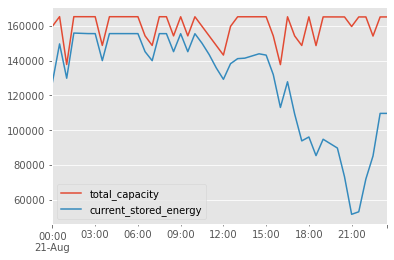

In [96]:
intp_batt_df[['total_capacity','current_stored_energy']].plot()
intp_batt_df['ratio']=

### lessening spikiness of data

In [88]:
# not sure if I want to do this